In [1]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from scipy.spatial import distance_matrix
from tqdm import tqdm

In [2]:
margin = 3
sample_size = 60000
batchSize = 40

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
toTensor = transforms.ToTensor()


xSub = x_train[:sample_size]
ySub = y_train[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

In [5]:
negative_i_dict = {}

for label in set(ySub):
    negative_i_dict[label] = [i for i in range(len(ySub)) if ySub[i] != label ]

negative_i_dict

{0: [0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  35,
  36,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  52,
  53,
  54,
  55,
  57,
  58,
  59,
  60,
  61,
  62,
  64,
  65,
  66,
  67,
  70,
  71,
  72,
  73,
  74,
  76,
  77,
  78,
  79,
  80,
  82,
  83,
  84,
  85,
  86,
  87,
  89,
  90,
  91,
  92,
  93,
  94,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  109,
  110,
  111,
  112,
  113,
  115,
  116,
  117,
  120,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  170,
  171,
  172,
  173,
  174,
  175,
 

In [6]:


model = nn.Sequential(  nn.Flatten(),
                        nn.Linear(28*28,256),
                        nn.ReLU(),
                        nn.Linear(256,32),
                        nn.Sigmoid()
                        )

optimizer = optim.SGD( model.parameters() )
criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                 margin=margin
                                 )

In [7]:
def getAPN(a, pos, dMatrix):
    aP = [a]+pos
    neg_i = [i for i in range(len(dMatrix)) if i not in aP ]

    outPut = []

    for p in  pos:
        posDist = dMatrix[a][p]
        
        legal_i = [i for i in neg_i if (posDist < dMatrix[a][i]) and (dMatrix[a][i] <= posDist+margin)] # i = "global" index of the Hash
        
        legal_dist = [dMatrix[a][i] for i in legal_i]
        
        if legal_dist == []: continue
        max_dist = min(legal_dist)

        n = legal_i[ legal_dist.index(max_dist) ]
        outPut.append( (a, p, n) )

    return outPut

In [8]:
import time

In [9]:
loss_list = []
for i in tqdm( range(40000) ):
    t1 = time.time()

    batch_i = random.sample(range(sample_size), batchSize)

    xBatch = torch.stack( [xTensor[j] for j in batch_i] )
    yBatch = [ySub[j] for j in batch_i]

    results = model(xBatch)
    results_np = results.detach().numpy()

    t2 = time.time()

    dMatrix = distance_matrix(results_np, results_np, p=1)

    t3 = time.time()

    APN_list = []

    for label in set(yBatch):
        pos_i_list = [j for j in range(len(yBatch)) if yBatch[j] == label]

        for anchor_i in pos_i_list:
            pos_i = [j for j in pos_i_list if j != anchor_i]

            APN_list += getAPN(anchor_i, pos_i, dMatrix)

    t4 = time.time()

    if len(APN_list) > 0:
        a_list = []
        p_list = []
        n_list = []

        for apn in APN_list:
            a_list.append(results[ apn[0] ])
            p_list.append(results[ apn[1] ])
            n_list.append(results[ apn[2] ])
        
        # === Improve Model ===
        optimizer.zero_grad()

        loss = criterion(torch.stack(a_list),
                        torch.stack(p_list),
                        torch.stack(n_list) )
        
        loss.backward()
        optimizer.step()

        loss_list.append( float(loss) )

    t5 = time.time()

    if (i % 2000) == 0: 
        print(f"Make Bacthes + get results: {t2-t1}\n", f"Distance Matrix: {t3-t2}\n", f"MAke APN List: {t4-t3}\n", f"Back Propegate: {t5-t4}")
        
        print(i, sum(loss_list) / len(loss_list) )
        loss_list = []


  0%|          | 10/40000 [00:00<06:54, 96.40it/s]

Make Bacthes + get results: 0.0020148754119873047
 Distance Matrix: 0.0
 MAke APN List: 0.002980947494506836
 Back Propegate: 0.006002664566040039
0 2.984905958175659


  5%|▌         | 2011/40000 [00:18<05:58, 106.04it/s]

Make Bacthes + get results: 0.0013132095336914062
 Distance Matrix: 0.0
 MAke APN List: 0.002107858657836914
 Back Propegate: 0.004899740219116211
2000 2.9443482489585877


 10%|█         | 4022/40000 [00:37<05:33, 107.80it/s]

Make Bacthes + get results: 0.0012099742889404297
 Distance Matrix: 0.0
 MAke APN List: 0.002100229263305664
 Back Propegate: 0.004941225051879883
4000 2.8324033068418504


 15%|█▌        | 6010/40000 [00:56<05:23, 105.10it/s]

Make Bacthes + get results: 0.0009706020355224609
 Distance Matrix: 0.0
 MAke APN List: 0.003018617630004883
 Back Propegate: 0.005033254623413086
6000 2.67429926776886


 20%|██        | 8017/40000 [01:14<04:48, 110.74it/s]

Make Bacthes + get results: 0.0019578933715820312
 Distance Matrix: 0.0
 MAke APN List: 0.002034902572631836
 Back Propegate: 0.00501561164855957
8000 2.431920565009117


 25%|██▌       | 10019/40000 [01:32<04:18, 116.20it/s]

Make Bacthes + get results: 0.0009982585906982422
 Distance Matrix: 0.0
 MAke APN List: 0.0019989013671875
 Back Propegate: 0.0057756900787353516
10000 2.1784498785734177


 30%|███       | 12024/40000 [01:49<03:44, 124.87it/s]

Make Bacthes + get results: 0.0010421276092529297
 Distance Matrix: 0.0
 MAke APN List: 0.0022323131561279297
 Back Propegate: 0.005972623825073242
12000 2.034212027728558


 35%|███▌      | 14022/40000 [02:05<03:11, 135.48it/s]

Make Bacthes + get results: 0.0010044574737548828
 Distance Matrix: 0.0
 MAke APN List: 0.002094745635986328
 Back Propegate: 0.003924131393432617
14000 1.9318902356028558


 40%|████      | 16028/40000 [02:20<02:51, 139.74it/s]

Make Bacthes + get results: 0.0
 Distance Matrix: 0.0009732246398925781
 MAke APN List: 0.001046895980834961
 Back Propegate: 0.0042798519134521484
16000 1.8506562875211239


 45%|████▌     | 18024/40000 [02:34<02:29, 146.54it/s]

Make Bacthes + get results: 0.0010349750518798828
 Distance Matrix: 0.0
 MAke APN List: 0.0020074844360351562
 Back Propegate: 0.0030515193939208984
18000 1.7973729299604893


 50%|█████     | 20014/40000 [02:47<02:14, 148.95it/s]

Make Bacthes + get results: 0.0010004043579101562
 Distance Matrix: 0.0
 MAke APN List: 0.0021708011627197266
 Back Propegate: 0.004137754440307617
20000 1.7495363311469554


 55%|█████▌    | 22025/40000 [03:00<01:56, 153.71it/s]

Make Bacthes + get results: 0.0
 Distance Matrix: 0.0010001659393310547
 MAke APN List: 0.0010166168212890625
 Back Propegate: 0.003222227096557617
22000 1.733782545208931


 60%|██████    | 24030/40000 [03:13<01:37, 163.59it/s]

Make Bacthes + get results: 0.0010466575622558594
 Distance Matrix: 0.0
 MAke APN List: 0.002105236053466797
 Back Propegate: 0.002936840057373047
24000 1.6884880566596985


 65%|██████▌   | 26023/40000 [03:25<01:23, 168.30it/s]

Make Bacthes + get results: 0.00016379356384277344
 Distance Matrix: 0.0
 MAke APN List: 0.002084970474243164
 Back Propegate: 0.003007650375366211
26000 1.6701502719968557


 70%|███████   | 28028/40000 [03:37<01:08, 174.68it/s]

Make Bacthes + get results: 0.0
 Distance Matrix: 0.0
 MAke APN List: 0.0030858516693115234
 Back Propegate: 0.0039179325103759766
28000 1.6498747336268424


 75%|███████▌  | 30022/40000 [03:48<01:06, 149.84it/s]

Make Bacthes + get results: 0.0011012554168701172
 Distance Matrix: 0.0
 MAke APN List: 0.001928091049194336
 Back Propegate: 0.0029821395874023438
30000 1.6305112208873034


 80%|████████  | 32016/40000 [04:02<00:56, 141.16it/s]

Make Bacthes + get results: 0.0009534358978271484
 Distance Matrix: 0.0
 MAke APN List: 0.002330303192138672
 Back Propegate: 0.0016307830810546875
32000 1.620467505544424


 85%|████████▌ | 34028/40000 [04:16<00:38, 156.04it/s]

Make Bacthes + get results: 0.0010175704956054688
 Distance Matrix: 0.0
 MAke APN List: 0.0020856857299804688
 Back Propegate: 0.0019965171813964844
34000 1.5988731310367583


 90%|█████████ | 36025/40000 [04:30<00:29, 135.19it/s]

Make Bacthes + get results: 0.0
 Distance Matrix: 0.0010104179382324219
 MAke APN List: 0.0020520687103271484
 Back Propegate: 0.003393888473510742
36000 1.5885510804504157


 95%|█████████▌| 38034/40000 [04:43<00:11, 173.31it/s]

Make Bacthes + get results: 0.0009145736694335938
 Distance Matrix: 0.0
 MAke APN List: 0.002095460891723633
 Back Propegate: 0.0027697086334228516
38000 1.5677426653351256


100%|██████████| 40000/40000 [04:54<00:00, 135.61it/s]


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

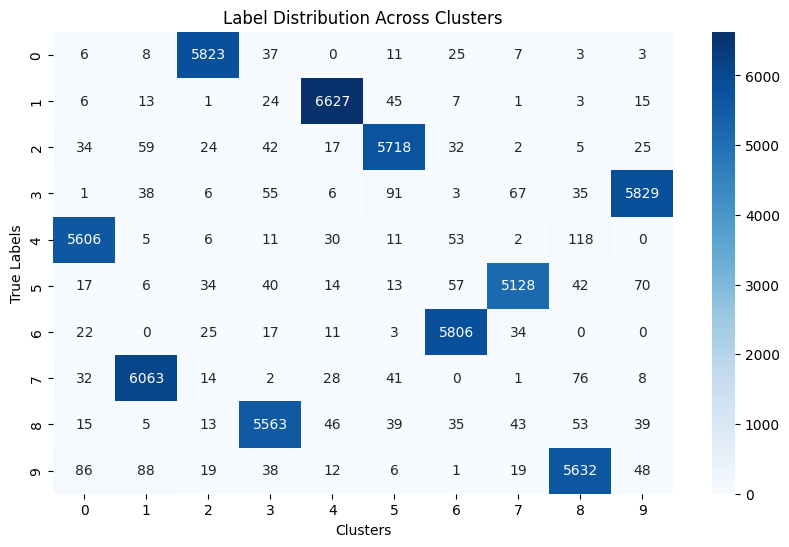

In [11]:
easyHeatmap(model(xTensor).detach().numpy(), ySub)

In [12]:


def mean_average_precision(test_hashes, labels):
    aps = []
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = labels[i]
        distances = np.abs(test_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.drop(index=i)
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        hash_df = hash_df.drop(["index", "distances"], axis=1).reset_index()
        hash_df = hash_df[hash_df["tp"]==1]
        hash_df["tp"] = hash_df["tp"].cumsum()
        hash_df["index"] = hash_df["index"] +1 
        precision = np.array(hash_df["tp"]) / np.array(hash_df["index"])
        ap = precision.mean()
        aps.append(ap)
    
    return np.array(aps).mean()

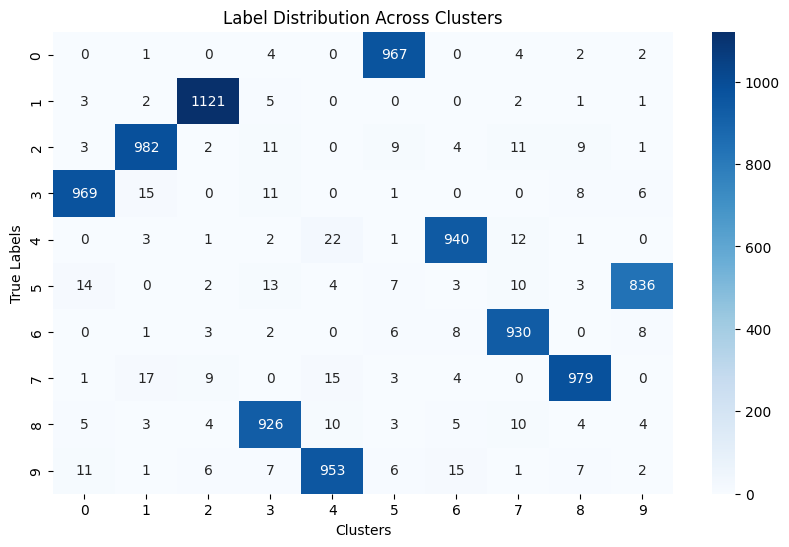

In [14]:
easyHeatmap(model( toTensor(x_test).permute(1, 0, 2).reshape(len(x_test), 1, 28, 28) ).detach().numpy(), y_test)

In [15]:
res = (model( toTensor(x_test).permute(1, 0, 2).reshape(len(x_test), 1, 28, 28) ).detach().numpy() > 0.5).astype(int)
mean_average_precision( res , y_test)

100%|██████████| 10000/10000 [00:49<00:00, 202.05it/s]


0.9393087868923973